In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
import os
import time
from tqdm import tqdm
from glob import glob
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader

In [2]:
%cd ./data/train/

/home/jupyter-deeplearning/Organize/data/train


In [3]:
def data_loader(files):
    out = []
    for file in tqdm(files):
        data = plt.imread(file)
        data = data.reshape(-1)
        out.append(data)    
    out = np.array(out,dtype=np.float32)
    return out

In [4]:
classes=sorted(glob("*"))

In [5]:
data_path=os.path.join(classes[0],"*.bmp")
data_path=glob(data_path)

In [6]:
image_shape=plt.imread((data_path[0])).shape
image_len=plt.imread((data_path[0])).size
print(image_shape)

(96, 96, 3)


In [7]:
train_data=np.zeros((1,image_len+1))
label_match=[]
for i,name in enumerate(classes):
    data_path=os.path.join(name,"*.bmp")
    data_path=glob(data_path)
    img_data=data_loader(data_path)
    img_data=np.insert(img_data, 0, i,axis=1)
    train_data=np.vstack([train_data,img_data])
    label_match.append([i,name])
train_data=np.delete(train_data,0,axis=0)

100%|██████████| 500/500 [00:00<00:00, 9940.38it/s]


In [8]:
print(label_match)

[[0, 'airplane'], [1, 'bird'], [2, 'car'], [3, 'cat'], [4, 'deer'], [5, 'dog'], [6, 'horse'], [7, 'monkey'], [8, 'ship'], [9, 'truck']]


In [9]:
# Data shuffle
np.take(train_data,np.random.permutation(train_data.shape[0]),
        axis=0,out=train_data)

array([[  8.,   0.,   0., ...,   0.,   0.,   0.],
       [  9., 122., 159., ...,   0.,   0.,   0.],
       [  8.,   0.,   0., ...,   0.,   0.,   0.],
       ...,
       [  9.,   0.,   0., ...,  15.,  16.,  17.],
       [  0.,  47.,  45., ..., 184., 151., 123.],
       [  2.,  19.,  37., ..., 177., 165., 153.]])

In [10]:
x_data=train_data[:,1:]
y_data=train_data[:,0]

In [11]:
# Data split
x_data_train, x_data_test, y_data_train, y_data_test = train_test_split(x_data, y_data, 
                                                                        test_size=0.2)

In [12]:
# Data normalization
x_data_train=x_data_train/x_data_train.max()
x_data_test=x_data_test/x_data_test.max()

In [13]:
class CustomDataset(Dataset):
    def __init__(self,x_dat,y_dat):
        x = x_dat
        y = y_dat
        self.len = x.shape[0]
        y=y.astype('int')
        x=x.astype('float32')
        self.x_data = torch.tensor(x)
        self.y_data = torch.tensor(y)

    def __getitem__(self, index):
        return self.x_data[index], self.y_data[index]

    def __len__(self):
        return self.len

In [14]:
batch_size=256
num_gpus=4
train_dataset = CustomDataset(x_data_train,y_data_train)
train_loader = DataLoader(dataset=train_dataset,pin_memory=True,
                          batch_size=batch_size,
                          shuffle=True,
                          num_workers=60,drop_last=True)
test_dataset = CustomDataset(x_data_test,y_data_test)
test_loader = DataLoader(dataset=test_dataset,pin_memory=True,
                          batch_size=batch_size,
                          shuffle=True,
                          num_workers=60,drop_last=True)

In [15]:
class Model(torch.nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.layer_1 = nn.Conv2d(in_channels=3,out_channels=64,kernel_size=3,
                                 stride=1,padding=2)
        self.act_1 = nn.ReLU()
        self.conv2_bn1 = nn.BatchNorm2d(64)
        
        self.layer_2 = nn.Conv2d(in_channels=64,out_channels=64,kernel_size=3,
                                 stride=1,padding=2)
        self.act_2 = nn.ReLU()
        self.conv2_bn2 = nn.BatchNorm2d(64)
        
        self.layer_3 = nn.Conv2d(in_channels=64,out_channels=64,kernel_size=3,
                                 stride=1,padding=2)
        self.act_3 = nn.ReLU()
        self.conv2_bn3 = nn.BatchNorm2d(64)
        
        self.max_1=nn.MaxPool2d(2,2)
        
        self.layer_4 = nn.Conv2d(in_channels=64,out_channels=128,kernel_size=3,
                                 stride=1,padding=2)
        self.act_4 = nn.ReLU()
        self.conv2_bn4 = nn.BatchNorm2d(128)

        self.layer_5 = nn.Conv2d(in_channels=128,out_channels=128,kernel_size=3,
                                 stride=1,padding=2)
        self.act_5 = nn.ReLU()
        self.conv2_bn5 = nn.BatchNorm2d(128)
        
        self.layer_6 = nn.Conv2d(in_channels=128,out_channels=128,kernel_size=3,
                                 stride=1,padding=2)
        self.act_6 = nn.ReLU()
        self.conv2_bn6 = nn.BatchNorm2d(128)
        self.max_2=nn.MaxPool2d(2,2)
        
        self.layer_7 = nn.Conv2d(in_channels=128,out_channels=256,kernel_size=3,
                                 stride=1,padding=2)
        self.act_7 = nn.ReLU()
        self.conv2_bn7 = nn.BatchNorm2d(256)
        
        self.layer_8 = nn.Conv2d(in_channels=256,out_channels=256,kernel_size=3,
                                 stride=1,padding=2)
        self.act_8 = nn.ReLU()
        self.conv2_bn8 = nn.BatchNorm2d(256)
        
        self.layer_9 = nn.Conv2d(in_channels=256,out_channels=256,kernel_size=3,
                                 stride=1,padding=2)
        self.act_9 = nn.ReLU()
        self.conv2_bn9 = nn.BatchNorm2d(256)
        
        self.max_3=nn.MaxPool2d(2,2)
        
        self.layer_10 = nn.Conv2d(in_channels=256,out_channels=512,kernel_size=3,
                                 stride=1,padding=2)
        self.act_10 = nn.ReLU()
        self.conv2_bn10 = nn.BatchNorm2d(512)
        
        self.layer_11 = nn.Conv2d(in_channels=512,out_channels=512,kernel_size=3,
                                 stride=1,padding=2)
        self.act_11 = nn.ReLU()
        self.conv2_bn11 = nn.BatchNorm2d(512)
        
        self.layer_12 = nn.Conv2d(in_channels=512,out_channels=512,kernel_size=3,
                                 stride=1,padding=2)
        self.act_12 = nn.ReLU()
        self.conv2_bn12 = nn.BatchNorm2d(512)
        
        self.max_4=nn.MaxPool2d(2,2)
        
        self.layer_13 = nn.Conv2d(in_channels=512,out_channels=1024,kernel_size=3,
                                 stride=1,padding=2)
        self.act_13 = nn.ReLU()
        self.conv2_bn13 = nn.BatchNorm2d(1024)
        
        self.layer_14 = nn.Conv2d(in_channels=1024,out_channels=1024,kernel_size=3,
                                 stride=1,padding=2)
        self.act_14 = nn.ReLU()
        self.conv2_bn14 = nn.BatchNorm2d(1024)
        
        self.max_5=nn.MaxPool2d(2,2)
        
        self.layer_15 = nn.Conv2d(in_channels=1024,out_channels=1024,kernel_size=1,
                                 stride=1)
        self.act_15 = nn.ReLU()
        self.conv2_bn15 = nn.BatchNorm2d(1024)
        
        self.layer_16 = nn.Conv2d(in_channels=1024,out_channels=1024,kernel_size=3,
                                 stride=1,padding=2)
        self.act_16 = nn.ReLU()
        self.conv2_bn16 = nn.BatchNorm2d(1024)
        
        self.layer_17 = nn.Conv2d(in_channels=1024,out_channels=1024,kernel_size=1,
                                 stride=1)
        self.act_17 = nn.ReLU()
        self.conv2_bn17 = nn.BatchNorm2d(1024)
        
        

        
        self.fc_layer_1 = nn.Linear(9*9*1024,1000)
        self.act_18 = nn.ReLU()
        
        self.bnm1=nn.BatchNorm1d(1000)
        
        self.fc_layer_2 = nn.Linear(1000,1000)
        self.act_19 = nn.ReLU()
        
        self.bnm2=nn.BatchNorm1d(1000)
        
        self.fc_layer_3 = nn.Linear(1000,100)
        self.act_20 = nn.ReLU()
        
        self.bnm3=nn.BatchNorm1d(100)
        
        self.fc_layer_4 = nn.Linear(100,10)
        self.act_21 = nn.ReLU()

        
        
        

    def forward(self, x):
        x = x.view(batch_size//num_gpus,3,96,96)
        out = self.layer_1(x)
        out = self.act_1(out)
        for module in list(self.modules())[2:-11]:
            out = module(out)
        out = out.view(batch_size//num_gpus,-1)
        for module in list(self.modules())[-11:]:
            out = module(out)
        return out

In [16]:
model=nn.DataParallel(Model().cuda())
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(),weight_decay=0.0001)

In [17]:
%cd /home/jupyter-deeplearning/res_model

/home/jupyter-deeplearning/res_model


In [18]:
trn_loss_list = []
val_loss_list = []
val_acc_list = []
total_epoch=200
model_char="minloss"
model_name=""
patience=5
start_early_stop_check=0
saving_start_epoch=10

for epoch in range(total_epoch):
    trn_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data
        if torch.cuda.is_available():
            inputs=inputs.cuda()
            labels=labels.cuda()
        # grad init
        optimizer.zero_grad()
        # forward propagation
        output= model(inputs)
        # calculate loss
        loss=criterion(output, labels)
        # back propagation 
        loss.backward()
        # weight update
        optimizer.step()
        
        # trn_loss summary
        trn_loss += loss.item()
        # del (memory issue)
        del loss
        del output
    with torch.no_grad():
        val_loss = 0.0
        cor_match = 0
        for j, val in enumerate(test_loader):
            val_x, val_label = val
            if torch.cuda.is_available():
                val_x = val_x.cuda()
                val_label =val_label.cuda()
            val_output = model(val_x)
            v_loss = criterion(val_output, val_label)
            val_loss += v_loss
            _, predicted=torch.max(val_output,1)
            cor_match+=np.count_nonzero(predicted.cpu().detach()==val_label.cpu().detach())
    del val_output
    del v_loss
    del predicted
    
    
    
    trn_loss_list.append(trn_loss/len(train_loader))
    val_loss_list.append(val_loss/len(test_loader))
    val_acc=cor_match/(len(test_loader)*batch_size)
    val_acc_list.append(val_acc)
    now = time.localtime()
    print ("%04d/%02d/%02d %02d:%02d:%02d" % (now.tm_year, now.tm_mon, now.tm_mday, now.tm_hour, now.tm_min, now.tm_sec))

    print("epoch: {}/{} | trn loss: {:.4f} | val loss: {:.4f} | val accuracy: {:.4f}% \n".format(
                epoch+1, total_epoch, trn_loss / len(train_loader), val_loss / len(test_loader), val_acc*100
            ))
    
    
    if epoch+1>2:
        if val_loss_list[-1]>val_loss_list[-2]:
            start_early_stop_check=1
    else:
        val_loss_min=val_loss_list[-1]
        
    if start_early_stop_check:
        early_stop_temp=val_loss_list[-patience:]
        if all(early_stop_temp[i]<early_stop_temp[i+1] for i in range (len(early_stop_temp)-1)):
            print("Early stop!")
            break
            
    if epoch+1>saving_start_epoch:
        if val_loss_list[-1]<val_loss_min:
            if os.path.isfile(model_name):
                os.remove(model_name)
            val_loss_min=val_loss_list[-1]
            model_name="Custom_model_"+model_char+"_{:.3f}".format(val_loss_min)
            torch.save(model, model_name)
            print("Model replaced and saved as ",model_name)

2020/10/28 13:52:13
epoch: 1/200 | trn loss: 2.1636 | val loss: 1.9726 | val accuracy: 26.6927% 

2020/10/28 13:52:27
epoch: 2/200 | trn loss: 1.9039 | val loss: 1.8036 | val accuracy: 33.4635% 

2020/10/28 13:52:41
epoch: 3/200 | trn loss: 1.7934 | val loss: 1.8390 | val accuracy: 30.5990% 

2020/10/28 13:52:55
epoch: 4/200 | trn loss: 1.7437 | val loss: 1.7614 | val accuracy: 34.7656% 

2020/10/28 13:53:10
epoch: 5/200 | trn loss: 1.7089 | val loss: 1.7078 | val accuracy: 36.1979% 

2020/10/28 13:53:24
epoch: 6/200 | trn loss: 1.6565 | val loss: 1.7499 | val accuracy: 35.5469% 

2020/10/28 13:53:39
epoch: 7/200 | trn loss: 1.6033 | val loss: 1.6400 | val accuracy: 39.0625% 

2020/10/28 13:53:53
epoch: 8/200 | trn loss: 1.5592 | val loss: 1.6511 | val accuracy: 38.9323% 

2020/10/28 13:54:07
epoch: 9/200 | trn loss: 1.5211 | val loss: 1.6312 | val accuracy: 39.8438% 

2020/10/28 13:54:22
epoch: 10/200 | trn loss: 1.4736 | val loss: 1.6578 | val accuracy: 39.5833% 

2020/10/28 13:54:36

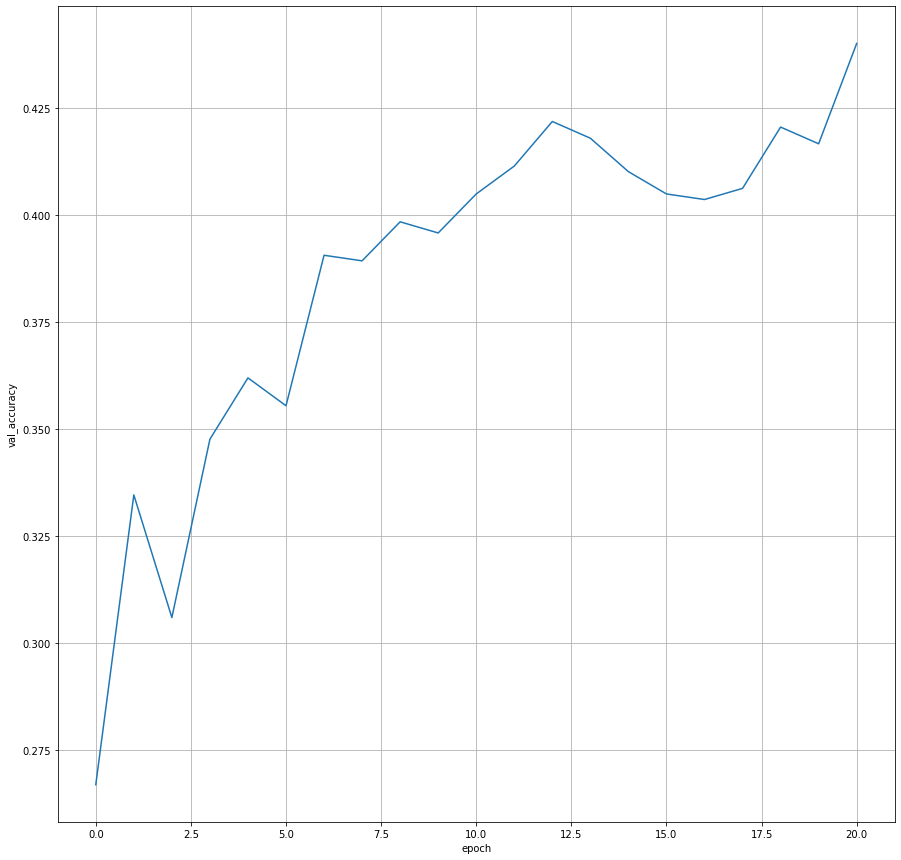

In [19]:
plt.figure(figsize=(15,15))
plt.ylabel("val_accuracy")
plt.xlabel("epoch")
plt.plot(val_acc_list)
plt.grid()

In [20]:
val_acc_list=np.array(val_acc_list)
np.savetxt("ver_1.0.txt", val_acc_list, delimiter=',')